## Description
This demonstrates training, validating, and testing a Swin Transformer-based model (swin_base_patch4_window7_224) for skin disease classification. It covers the entire pipeline from data preprocessing to model evaluation and visualization of metrics, leveraging PyTorch and associated libraries for high-performance deep learning tasks.

## Ignore Warnings
Suppresses unnecessary warnings for cleaner output.

In [9]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Library Imports
Imports libraries for data loading (torchvision), model creation (timm), evaluation metrics (sklearn), and visualization (matplotlib, tabulate).

In [10]:
import os
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate
from torch.cuda.amp import GradScaler, autocast
from collections import Counter
import numpy as np

## Device Setup
Checks for GPU availability and sets the computation device (CUDA or CPU).

In [11]:
import torch
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Running on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Running on CPU")

Running on GPU: NVIDIA GeForce RTX 4080


## Data Preprocessing

Sets dataset path and parameters like batch size, epochs, and learning rate.
Defines data augmentation transformations.
Splits the dataset into training, validation, and testing sets (70-20-10 split).
Calculates class weights for addressing dataset imbalance and sets up weighted sampling for training.

In [12]:
data_dir = r'D:\Umar\Dermnet'
batch_size = 64
num_epochs = 20
learning_rate = 1e-4
num_classes = 24  # Update if different

# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Dataset Split
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Calculate class weights for the training dataset
def calculate_class_weights(dataset):
    targets = [target for _, target in dataset]
    class_counts = Counter(targets)
    total_count = len(targets)
    class_weights = {cls: total_count / (len(class_counts) * count) for cls, count in class_counts.items()}
    weights = torch.tensor([class_weights[target] for _, target in dataset], dtype=torch.float)
    return weights

train_weights = calculate_class_weights(train_dataset)

# Print class weights for verification
print("Class weights:", train_weights)

# Create DataLoaders
# Adjust `num_workers` to optimize based on system performance
train_sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

# Print dataset sizes for verification
print(f"Dataset sizes: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")

Class weights: tensor([3.1954, 1.5166, 0.5281,  ..., 0.5901, 0.4926, 2.8149])
Dataset sizes: Train=111199, Validation=31771, Test=15887


## Model Definition

Initializes a Swin Transformer model (swin_base_patch4_window7_224) pre-trained on ImageNet.
Defines the loss function (CrossEntropy), optimizer (AdamW), and learning rate scheduler for adaptive learning.

In [13]:
# Model Definition
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Mixed Precision Training
scaler = GradScaler()

## Metrics Calculation and Training

Implements functions to compute metrics (accuracy, F1 score, precision, recall).
Sets up training and validation loops with mixed precision for efficient computation.
Tracks and logs metrics at each epoch.

In [14]:
# Metrics Calculation
def compute_metrics(preds, targets):
    accuracy = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    precision = precision_score(targets, preds, average='weighted', zero_division=0)
    recall = recall_score(targets, preds, average='weighted', zero_division=0)
    return accuracy, f1, precision, recall

# Store metrics for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

# Training and Validation Loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss, train_corrects, train_preds, train_targets = 0.0, 0, [], []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

    # Compute training metrics
    train_loss = train_loss / len(train_loader.dataset)
    train_acc, train_f1, train_prec, train_recall = compute_metrics(train_preds, train_targets)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    train_precisions.append(train_prec)
    train_recalls.append(train_recall)

    # Validation Phase
    model.eval()
    val_loss, val_corrects, val_preds, val_targets = 0.0, 0, [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    # Compute validation metrics
    val_loss = val_loss / len(val_loader.dataset)
    val_acc, val_f1, val_prec, val_recall = compute_metrics(val_preds, val_targets)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    val_precisions.append(val_prec)
    val_recalls.append(val_recall)

    # Print metrics
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}')
    print(f'Precision: {val_prec:.4f}, Recall: {val_recall:.4f}')

    # Print table
    table = [
        ["Epoch", "Train Loss", "Train Accuracy", "Train F1 Score", "Train Precision", "Train Recall", 
         "Val Loss", "Val Accuracy", "Val F1 Score", "Val Precision", "Val Recall"],
        [epoch + 1, train_loss, train_acc, train_f1, train_prec, train_recall, val_loss, val_acc, val_f1, val_prec, val_recall]
    ]
    print(tabulate(table, headers="firstrow", tablefmt="grid"))

    # Update learning rate
    scheduler.step()

Epoch 1/20
Training Loss: 1.0485, Accuracy: 0.6889, F1 Score: 0.6864
Validation Loss: 0.5578, Accuracy: 0.8246, F1 Score: 0.8224
Precision: 0.8318, Recall: 0.8246
+---------+--------------+------------------+------------------+-------------------+----------------+------------+----------------+----------------+-----------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Train F1 Score |   Train Precision |   Train Recall |   Val Loss |   Val Accuracy |   Val F1 Score |   Val Precision |   Val Recall |
+=========+==============+==================+==================+===================+================+============+================+================+=================+==============+
|       1 |      1.04849 |         0.688891 |          0.68638 |          0.685725 |       0.688891 |   0.557832 |       0.824557 |       0.822371 |        0.831763 |     0.824557 |
+---------+--------------+------------------+------------------+-------------------+----------------+--------

## Testing Phase

Evaluates the model on the test set.
Logs metrics (loss, accuracy, F1 score, precision, recall) for each epoch

In [15]:
# Initialize lists to store metrics for each epoch
test_losses = []
test_accuracies = []
test_f1_scores = []
test_precisions = []
test_recalls = []

# Testing Phase (for each epoch)
model.eval()
with torch.no_grad():
    for epoch in range(num_epochs):  # Replace `num_epochs` with the total number of epochs
        test_loss, test_corrects, test_preds, test_targets = 0.0, 0, [], []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

        # Compute test metrics for this epoch
        epoch_loss = test_loss / len(test_loader.dataset)
        epoch_acc, epoch_f1, epoch_prec, epoch_recall = compute_metrics(test_preds, test_targets)

        # Append metrics to lists
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        test_f1_scores.append(epoch_f1)
        test_precisions.append(epoch_prec)
        test_recalls.append(epoch_recall)

## Model Saving
Saves the trained model's weights as a .pth file for future use.

In [16]:
# Save the Model
torch.save(model.state_dict(), 'swin_skin_disease_model_with3.pth')

## Visualization of Metrics

Plots loss, accuracy, precision, recall, and F1 score for training, validation, and testing over epochs.
Ensures clear presentation and comparison of performance trends.

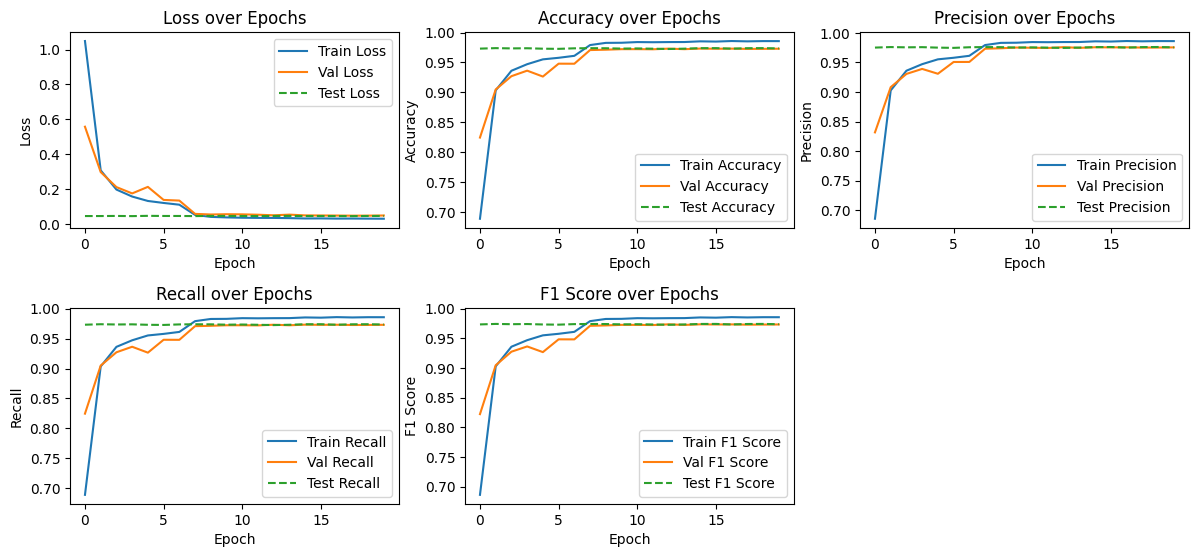

In [ ]:
# Visualization: Loss and Accuracy
plt.figure(figsize=(12, 8))

# Plot losses
plt.subplot(3, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracies
plt.subplot(3, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot precision-recall curves
plt.subplot(3, 3, 3)
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Val Precision')
plt.plot(test_precisions, label='Test Precision', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision over Epochs')

plt.subplot(3, 3, 4)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Val Recall')
plt.plot(test_recalls, label='Test Recall', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall over Epochs')

plt.subplot(3, 3, 5)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.plot(test_f1_scores, label='Test F1 Score', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score over Epochs')

plt.tight_layout()
plt.show()

## Confusion Matrix

Generates a confusion matrix to visualize classification performance on the test set.
Customizes the plot with enhanced labeling, gridlines, and annotations for clarity.

In [ ]:
# Import necessary packages
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with autocast():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)

# Enhanced plot settings
plt.figure(figsize=(15, 15))
ax = plt.gca()
disp.plot(cmap=plt.cm.Oranges, ax=ax, colorbar=True)

# Customize ticks and labels
plt.title('Confusion Matrix of Skin Disease Classification', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha="right")
plt.yticks(fontsize=10)

# Add grid
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

# Display values in each cell
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()